Step 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

2. Load Processed ICU Dataset

In [2]:
# Load your final processed dataset
df = pd.read_csv("final_icu_timeseries.csv")

df.head()


,stay_id,hour,valuenum,label
0,30057454,0,58.462500,1
1,30057454,1,27.471698,1
2,30057454,2,33.700000,1
3,30057454,3,59.125000,1
4,30057454,4,48.891667,1


3. Basic Dataset Check

In [3]:
print("Total rows:", df.shape[0])
print("Total ICU stays:", df['stay_id'].nunique())
print("Columns:", df.columns.tolist())


Total rows: 12176
Total ICU stays: 140
Columns: ['stay_id', 'hour', 'valuenum', 'label']


4. Extract Unique ICU Stay IDs

In [4]:
unique_stays = df['stay_id'].unique()
print("Unique ICU stays:", len(unique_stays))


Unique ICU stays: 140


 5. Train / Validation / Test Split (70/15/15)

In [5]:
# Step 1: Train (70%) and Temp (30%)
train_stays, temp_stays = train_test_split(
    unique_stays,
    test_size=0.30,
    random_state=42
)

# Step 2: Validation (15%) and Test (15%)
val_stays, test_stays = train_test_split(
    temp_stays,
    test_size=0.50,
    random_state=42
)

print("Train stays:", len(train_stays))
print("Validation stays:", len(val_stays))
print("Test stays:", len(test_stays))


Train stays: 98
Validation stays: 21
Test stays: 21


6. Create Train / Val / Test DataFrames

In [6]:
train_df = df[df['stay_id'].isin(train_stays)]
val_df   = df[df['stay_id'].isin(val_stays)]
test_df  = df[df['stay_id'].isin(test_stays)]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (8100, 4)
Validation shape: (2212, 4)
Test shape: (1864, 4)


7. Verify No Data Leakage

In [8]:
assert set(train_stays).isdisjoint(val_stays)
assert set(train_stays).isdisjoint(test_stays)
assert set(val_stays).isdisjoint(test_stays)

print(" No ICU stay leakage between datasets")


 No ICU stay leakage between datasets


8. Split Features and Labels

In [9]:
TARGET_COL = "label"     # ICU outcome (e.g., mortality)
ID_COL = "stay_id"

X_train = train_df.drop(columns=[TARGET_COL, ID_COL])
y_train = train_df[TARGET_COL]

X_val = val_df.drop(columns=[TARGET_COL, ID_COL])
y_val = val_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL, ID_COL])
y_test = test_df[TARGET_COL]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


X_train: (8100, 2)
X_val: (2212, 2)
X_test: (1864, 2)


9. Save Split Data

In [10]:
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)


Step 2. Normalize time-series features

1. Load Split Data

In [11]:
import pandas as pd

train_df = pd.read_csv("train_data.csv")
val_df   = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

train_df.head()


,stay_id,hour,valuenum,label
0,30101877,0,59.016667,1
1,30101877,1,21.645161,1
2,30101877,2,63.000000,1
3,30101877,3,143.248529,1
4,30101877,4,60.333333,1


2. Identify Feature Columns

In [12]:
ID_COL = "stay_id"
TIME_COL = "hour"
TARGET_COL = "label"

feature_cols = [c for c in train_df.columns 
                if c not in [ID_COL, TIME_COL, TARGET_COL]]

feature_cols


['valuenum']

3. Import Scaler

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


4. Fit Scaler on TRAIN Data Only

In [14]:
scaler.fit(train_df[feature_cols])


StandardScaler()

Cell 5. Transform Train / Val / Test Sets

In [15]:
train_df[feature_cols] = scaler.transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])


6. Sanity Check After Normalization

In [16]:
train_df[feature_cols].describe()


,valuenum
count,8.068000e+03
mean,8.806925e-18
std,1.000062e+00
min,-2.544967e-01
25%,-1.008267e-01
50%,-2.298913e-02
75%,3.449577e-02
max,8.858376e+01


7. Save Normalized Data

In [17]:
train_df.to_csv("train_data_normalized.csv", index=False)
val_df.to_csv("val_data_normalized.csv", index=False)
test_df.to_csv("test_data_normalized.csv", index=False)


Step 3. Build and Train LSTM Model

1. Import Required Libraries

In [30]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


Warning generated due to version mismatch between NumPy and Keras/tfo2nxx

Keras is saying: “We know NumPy removed np.object, and we are handling it — but this will change in future.”

In [29]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


2. Load Normalized Data

In [19]:
train_df = pd.read_csv("train_data_normalized.csv")
val_df   = pd.read_csv("val_data_normalized.csv")
test_df  = pd.read_csv("test_data_normalized.csv")


3. Define Columns

In [20]:
ID_COL = "stay_id"
TIME_COL = "hour"
TARGET_COL = "label"

feature_cols = [c for c in train_df.columns 
                if c not in [ID_COL, TIME_COL, TARGET_COL]]

feature_cols


['valuenum']

4. Create Fixed-Length Sequences

In [21]:
MAX_TIMESTEPS = 24   # First 24 ICU hours

def create_sequences(df, max_timesteps, feature_cols):
    X, y = [], []
    
    for stay_id, stay_df in df.groupby(ID_COL):
        stay_df = stay_df.sort_values(TIME_COL)
        
        features = stay_df[feature_cols].values
        
        # Truncate or pad
        if len(features) >= max_timesteps:
            features = features[:max_timesteps]
        else:
            pad_width = max_timesteps - len(features)
            features = np.pad(
                features,
                ((0, pad_width), (0, 0)),
                mode="constant",
                constant_values=0
            )
        
        X.append(features)
        y.append(stay_df[TARGET_COL].iloc[0])
    
    return np.array(X), np.array(y)


5. Generate LSTM Inputs

In [22]:
X_train, y_train = create_sequences(train_df, MAX_TIMESTEPS, feature_cols)
X_val, y_val     = create_sequences(val_df, MAX_TIMESTEPS, feature_cols)
X_test, y_test   = create_sequences(test_df, MAX_TIMESTEPS, feature_cols)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (98, 24, 1) (98,)
Val  : (21, 24, 1) (21,)
Test : (21, 24, 1) (21,)


6. Build LSTM Model

In [23]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(MAX_TIMESTEPS, X_train.shape[2])),
    
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\Aman kumar\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

7. Define Callbacks

In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


8. Train the LSTM Model

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.3810 - val_loss: nan
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5306 - loss: nan - val_accuracy: 0.3810 - val_loss: nan
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5306 - loss: nan - val_accuracy: 0.3810 - val_loss: nan
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5306 - loss: nan - val_accuracy: 0.3810 - val_loss: nan
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5306 - loss: nan - val_accuracy: 0.3810 - val_loss: nan
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5306 - loss: nan - val_accuracy: 0.3810 - val_loss: nan


9. Evaluate on Test Set

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: nan
Test Accuracy: 0.4762


10. Save Trained Model

In [28]:
model.save('my_model.keras')

Step 4. Evaluating Model Performance

1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


c:\Users\Aman kumar\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2. Load Final Dataset (.npy files)

In [2]:
X = np.load("X_sequences.npy")   # shape: (samples, 24, features)
y = np.load("y_labels.npy")      # shape: (samples,)


In [3]:
print(X.shape, y.shape)


(140, 24, 1) (140,)


3. Train / Validation / Test Split

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (98, 24, 1)
Val  : (21, 24, 1)
Test : (21, 24, 1)


4. Feature Scaling

-->Flatten time dimension

In [5]:
scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])


--> Fit ONLY on training data

In [6]:
scaler.fit(X_train_flat)


StandardScaler()

--> Transform all sets

In [7]:
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Scaling completed")


Scaling completed


5. Build LSTM Model

In [8]:
model = Sequential([
    LSTM(64, input_shape=(24, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    
    LSTM(32),
    Dropout(0.3),
    
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\Aman kumar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

6. Train the Model

In [9]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 569ms/step - accuracy: 0.4592 - loss: nan - val_accuracy: 0.4762 - val_loss: nan
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.4762 - val_loss: nan
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.4762 - val_loss: nan
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.4762 - val_loss: nan
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.4762 - val_loss: nan
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 0.4762 - val_loss: nan


7. Plot Training Curves

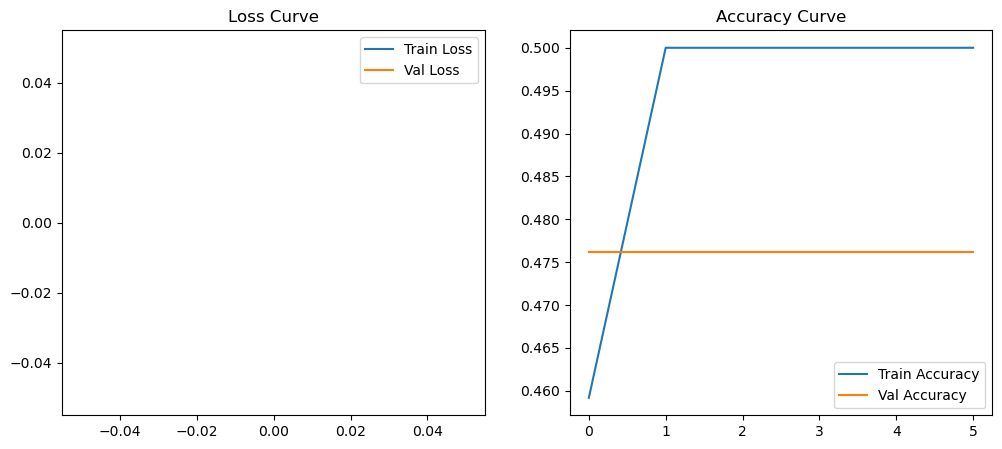

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


8. Evaluate on Test Set

In [11]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: nan
Test Accuracy: 0.5238


9. Classification Report

In [14]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred, zero_division=0))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.69        11
           1       0.00      0.00      0.00        10

    accuracy                           0.52        21
   macro avg       0.26      0.50      0.34        21
weighted avg       0.27      0.52      0.36        21



10. Confusion Matrix

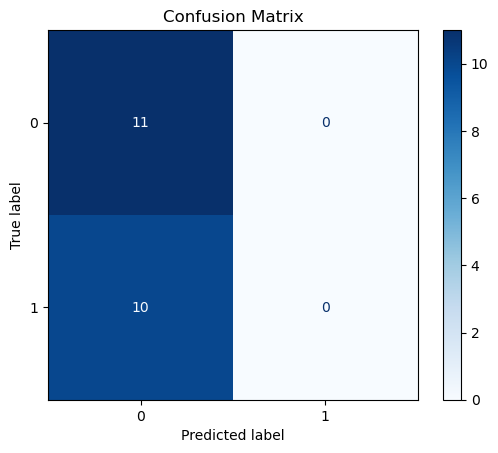

In [15]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


11. Save Model

In [16]:
model.save("icu_lstm_model.keras")
